In [1]:
import pandas as pd
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

# Set random seed for reproducibility
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  42


### Fake sin & cos data

(51200, 2)
        sin       cos
0  0.000000  1.000000
1  0.005000  0.999987
2  0.010000  0.999950
3  0.015000  0.999887
4  0.019999  0.999800


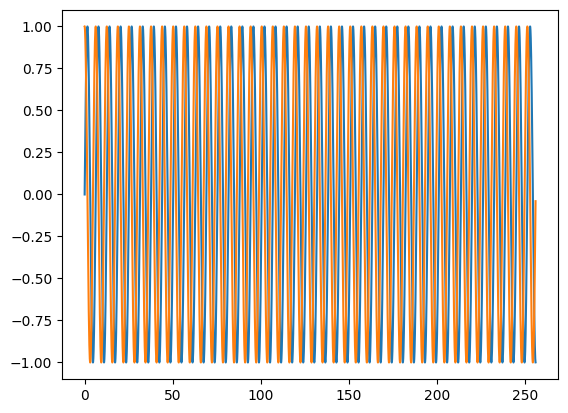

In [2]:
from sklearn.model_selection import train_test_split

#generate sinusoidal signal with 102400 samples
x = np.linspace(0, 256, 51200)
sin = np.sin(x)

# plot data
plt.plot(x, sin)

# generate cosine signal with 102400 samples
x = np.linspace(0, 256, 51200)
cos = np.cos(x)

# plot data
plt.plot(x, cos)

#create a dataframe with the sine and cosine signals
df = pd.DataFrame({'sin': sin, 'cos': cos})
print(df.shape)
print(df.head())

# split data into training and test set 
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False, stratify = None)

In [3]:
class SignalDataset(Dataset):
    def __init__(self, signal_A, signal_B, df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]

        # creating tensor from df 
        self.tensor_A = torch.tensor(self.df[signal_A].values)
        self.tensor_B = torch.tensor(self.df[signal_B].values)

        # split tensor into tensors of size 100
        self.tensor_A = self.tensor_A.split(256)    
        self.tensor_B = self.tensor_B.split(256)   # split in such a way, that only data from one pig is in one tensor
                                                   # add zero padding to tensors that are smaller than 100

        self.tensor_A = torch.stack(self.tensor_A).unsqueeze(1) #solves batch size problem
        self.tensor_B = torch.stack(self.tensor_B).unsqueeze(1) #solves batch size problem
   

    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index  # add data augmentation?
        return self.tensor_A[index], self.tensor_B[index]

In [4]:
SIG_A = "sin"  
SIG_B = "cos"

# create datasets with class SignalDataset
train_dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
test_dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, num_workers=10, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True,)

# length of train and test dataset
print(len(train_dataset), len(test_dataset))

160 40


$D(x)$ is the discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.x1 = self.conv1 = nn.Conv1d(in_channels= 1, out_channels= 32, kernel_size = 3, stride = 2, padding =1)
        self.x2 = self.conv2 = nn.Conv1d(in_channels= 32, out_channels= 64, kernel_size = 3, stride = 2, padding =1)
        self.x3 = self.conv3 = nn.Conv1d(in_channels= 64, out_channels= 128, kernel_size = 3, stride = 2, padding =1)
        self.x4 = self.conv4 = nn.Conv1d(in_channels= 128, out_channels= 1, kernel_size = 3, stride = 2, padding =1)
        
        self.out = nn.Sigmoid()


    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x = self.conv5(x)
        #x = self.conv6(x)
        x = self.out(x)
        return x
    
x = torch.randn(1, 1, 128)
discriminator = Discriminator()
print(discriminator(x).shape)

torch.Size([1, 1, 8])


In [6]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.InstanceNorm1d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.block(x)
    
#x = torch.randn((1, 1, 128))
#block = Block(1, 32, 2)
#print(block(x).shape)

class AP_Discriminator(nn.Module):
    def __init__(self, in_channels=1, out_channels=[32,64,128,256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv1d(in_channels, out_channels[0], kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        layers = []
        in_channels = out_channels[0]
        for out_channel in out_channels[1:]:
            layers.append(Block(in_channels, out_channel, stride=1 if out_channel == 256 else 2))
            in_channels = out_channel

        layers.append(nn.Conv1d(out_channels[-1], 1, kernel_size=3, stride=1, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))
    
x = torch.randn((1, 1, 256))
disc = AP_Discriminator()
print(disc(x).shape)

torch.Size([1, 1, 32])


### UnetGenerator

In [7]:
def double_conv_pad(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        # nn.InstanceNorm1d(out_channels),  # InstanceNorm1d is not working
        # nn.BatchNorm1d(out_channels),  # BatchNorm1d is not working
        nn.LeakyReLU(inplace=True),
        nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        #nn.InstanceNorm1d(out_channels), # InstanceNorm1d is not working
        # nn.BatchNorm1d(out_channels),  # BatchNorm1d is not working
        nn.LeakyReLU(inplace=True)
    ) 

class UnetGenerator(nn.Module):
    def __init__(self):
        super(UnetGenerator, self).__init__()
        self.maxpool = nn.MaxPool1d(2)

        self.down_conv1 = double_conv_pad(1, 32) 
        self.down_conv2 = double_conv_pad(32, 64) 
        self.down_conv3 = double_conv_pad(64, 128)
        self.down_conv4 = double_conv_pad(128, 256)

        self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.up_conv1 = double_conv_pad(256, 128)
        self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.up_conv2 = double_conv_pad(128, 64)
        self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.up_conv3 = double_conv_pad(64, 32)

        self.out = nn.Conv1d(32, 1, kernel_size=1)

    def forward(self, input):
        
        # batch_size, channels, tensor_size
        # encoder input -> 1, 1, 572
        #print(input.size())
        x1 = self.down_conv1(input)  # 
        #print(x1.size())  
        x2 = self.maxpool(x1) 
        #print(x2.size())
        x3 = self.down_conv2(x2)  #
        #print(x3.size())
        x4 = self.maxpool(x3) 
        #print(x4.size()) 
        x5 = self.down_conv3(x4)  #
        #print(x5.size()) 
        x6 = self.maxpool(x5)
        #print(x6.size())  
        x7 = self.down_conv4(x6)
        #print(x7.size())

        # decoder
        x = self.up_trans1(x7)
        x = self.up_conv1(torch.cat([x, x5], 1))
        x = self.up_trans2(x)
        x = self.up_conv2(torch.cat([x, x3], 1))
        x = self.up_trans3(x)
        x = self.up_conv3(torch.cat([x, x1], 1))
        x = self.out(x)
        #print(x.size())
        return x
    
x = torch.rand(1,1,256)
model = UnetGenerator()
#print(model(x))  # The model outputs a tensor of size 1, 1, 256, perfect
print(model(x).shape)

torch.Size([1, 1, 256])


### Training

In [8]:
# config

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4  #1024 didn't work so well
LEARNING_RATE = 1e-5  # 1e-5 works well
LAMBDA_IDENTITY = 0.1
LAMBDA_CYCLE = 10.0
NUM_WORKERS = 10
NUM_EPOCHS = 100
LR_DECAY_AFTER_EPOCH = 400  # if LR_DECAY_AFTER_EPOCH = NUM_EPOCHS -> no decay
GENERATION_AFTER_EPOCH = NUM_EPOCHS # generate a signal after the last epoch
LOAD_MODEL = False
SAVE_MODEL = False
SIG_A = 'sin' 
SIG_B = 'cos' 
CHECKPOINT_GEN_A2B = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_B)
CHECKPOINT_GEN_B2A = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_A =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_B =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_B)

Generate fake signals
Check


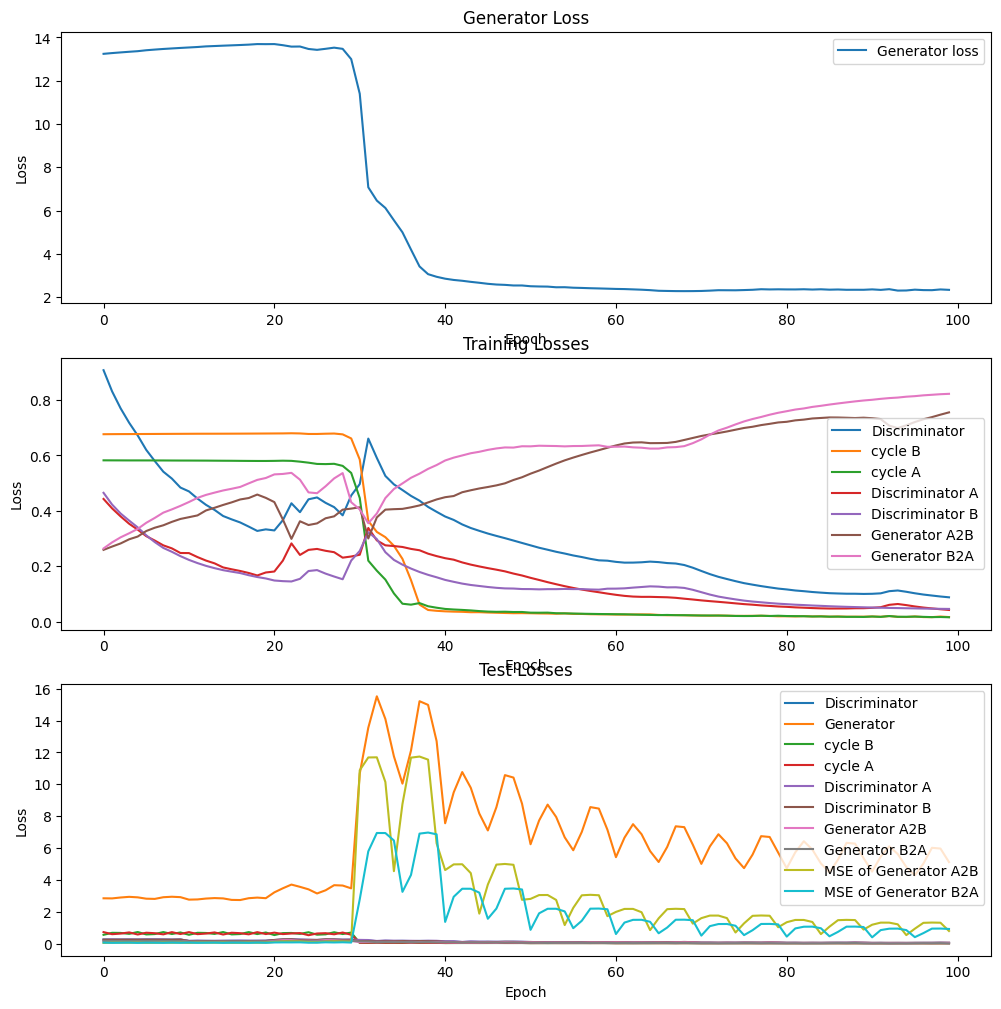

In [13]:
# initialize generator and discriminator
gen_A = UnetGenerator().to(DEVICE)
gen_B = UnetGenerator().to(DEVICE)
disc_A = AP_Discriminator().to(DEVICE)
disc_B = AP_Discriminator().to(DEVICE)

# optimizers for discriminator and generator 
opt_disc = torch.optim.AdamW(                                           # Adam statt AdamW 
    list(disc_A.parameters()) + list(disc_B.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=LEARNING_RATE,
)

gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = 2,
                                                    )
disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = 2,
                                                    )

l1 = nn.L1Loss() # L1 loss for cycle consistency and identity loss
mse = nn.MSELoss() # MSE loss for adversarial loss

# create datasets with class SignalDataset
dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_train)
test_dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)
gen_dataset = SignalDataset(signal_A=SIG_A, signal_B=SIG_B, df=df_test)

# Data loader
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True,)
gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=False, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

train_losses = {
            'cycle_B_loss': [],
            'cycle_A_loss': [],
            'identity_A_loss': [],
            'identity_B_loss': [],
            'disc_A_loss': [],
            'disc_B_loss': [],
            'gen_A2B_loss': [],
            'gen_B2A_loss': [],
            'd_loss': [],
            'g_loss': [],
        }

test_losses = {
    'cycle_B_loss': [],
    'cycle_A_loss': [],
    'disc_A_loss': [],
    'disc_B_loss': [],
    'gen_A2B_loss': [],
    'gen_B2A_loss': [],
    'd_loss': [],
    'g_loss': [],
    'mse_G_A2B': [],
    'mse_G_B2A': [],
}

B_reals = 0
B_fakes = 0


# training loop

for epoch in range(NUM_EPOCHS):

    for sig_A, sig_B in loader:
        # convert to float16
        sig_A = sig_A.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        sig_B = sig_B.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        sig_A = sig_A.to(DEVICE)
        sig_B = sig_B.to(DEVICE)

        #  -------------------------------- #
        #  ----- train discriminators ----- #
        #  -------------------------------- #
        with torch.cuda.amp.autocast(): # necessary for float16

            fake_B = gen_B(sig_A) # generate fake signal B
            d_B_real = disc_B(sig_B) # output of discriminator B for real signal B
            d_B_fake = disc_B(fake_B.detach()) # output of discriminator B for fake signal B (detached from generator)

            B_reals += d_B_real.mean().item()
            B_fakes += d_B_fake.mean().item()

            # Loss between dicriminator (with real signal) output and 1 - The discriminator should output 1 for real signals
            d_B_real_loss = mse(d_B_real, torch.ones_like(d_B_real))  
            # Loss between dicriminator (with fake signal) output and 0 - The discriminator should output 0 for fake signals
            d_B_fake_loss = mse(d_B_fake, torch.zeros_like(d_B_fake)) 
            # Total loss for discriminator B
            d_B_loss = d_B_real_loss + d_B_fake_loss

            fake_A = gen_A(sig_B)
            d_A_real = disc_A(sig_A)
            d_A_fake = disc_A(fake_A.detach()) 
            d_A_real_loss = mse(d_A_real, torch.ones_like(d_A_real)) 
            d_A_fake_loss = mse(d_A_fake, torch.zeros_like(d_A_fake))  
            d_A_loss = d_A_real_loss + d_A_fake_loss

            # Total loss for discriminator A
            d_loss = d_A_loss + d_B_loss  # in cycle GAN paper they halve the loss

        # exit amp.auto_cast() context manager and backpropagate 
        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()
        

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 
        with torch.cuda.amp.autocast():

            # ----- adversarial loss for both generators ----- #
            d_A_fake = disc_A(fake_A) # disc_A should output 0 for fake signal A
            d_B_fake = disc_B(fake_B) # disc_B should output 0 for fake signal B
            # loss between discriminator output and 0 - The discriminator should output 0 for fake signals
            g_A_loss = mse(d_A_fake, torch.ones_like(d_A_fake)) # was ones_like before  
            g_B_loss = mse(d_B_fake, torch.ones_like(d_B_fake)) # was ones_like before

            # ----- cycle consistency loss ----- #
            cycle_B = gen_B(fake_A) # fake_A = gen_B2A(sig_B)  
            cycle_A = gen_A(fake_B) # fake_B = gen_A2B(sig_A)
            cycle_B_loss = l1(sig_B, cycle_B)  # l1 loss: Mean absolute error between each element in the input x and target y.
            cycle_A_loss = l1(sig_A, cycle_A)

            # ----- identity loss ----- #
            id_B = gen_B(sig_B) 
            id_A = gen_A(sig_A)
            id_B_loss = l1(sig_B, id_B)
            id_A_loss = l1(sig_A, id_A)

            # put it all together
            g_loss = (
                g_A_loss +
                g_B_loss +
                cycle_B_loss * LAMBDA_CYCLE +
                cycle_A_loss * LAMBDA_CYCLE +
                id_B_loss * LAMBDA_IDENTITY +  # LAMBDA_IDENTITY = 0.0 -> no identity loss 
                id_A_loss * LAMBDA_IDENTITY    # we could remove it to increase training speed
            )

        # update gradients of generator
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

    # save losses
    train_losses['d_loss'].append(d_loss.item())
    train_losses['g_loss'].append(g_loss.item())
    train_losses['cycle_B_loss'].append(cycle_B_loss.item())
    train_losses['cycle_A_loss'].append(cycle_A_loss.item())
    #train_losses['identity_A_loss'].append(id_A_loss.item())
    #train_losses['identity_B_loss'].append(id_B_loss.item())
    train_losses['disc_A_loss'].append(d_A_loss.item())
    train_losses['disc_B_loss'].append(d_B_loss.item())
    train_losses['gen_A2B_loss'].append(g_A_loss.item())
    train_losses['gen_B2A_loss'].append(g_B_loss.item())

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    #  validation every 10 epochs
    if (epoch+1) % 10 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_A.eval()  # set discriminator to evaluation mode
            disc_B.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_B.eval()
            gen_A.eval()

            # store losses for testing
            test_mse_G_A2B = 0
            test_mse_G_B2A = 0
            test_g_A_loss = 0
            test_g_B_loss = 0
            test_cycle_B_loss = 0
            test_cycle_A_loss = 0
            test_d_A_loss = 0
            test_d_B_loss = 0
            test_g_loss = 0
            test_d_loss = 0

            for sig_A, sig_B in test_loader:
                # convert to float16
                sig_A = sig_A.float()
                sig_B = sig_B.float()

                # move to GPU
                sig_A = sig_A.to(DEVICE)
                sig_B = sig_B.to(DEVICE)

                fake_B = gen_B(sig_A)
                fake_A = gen_A(sig_B)
        
                # calculate mse loss of fake signals and real signals
                test_mse_G_A2B = mse(sig_B, fake_B)
                test_mse_G_B2A = mse(sig_A, fake_A)

                # calculate Generator loss
                test_g_A_loss = mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B))) #was ones_like before
                test_g_B_loss = mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))

                # ----- cycle loss ----- #
                cycle_B = gen_B(fake_A)  # fake_A = gen_B2A(sig_B)
                cycle_A = gen_A(fake_B)  # fake_B = gen_A2B(sig_A)
                test_cycle_B_loss = l1(sig_B, cycle_B)
                test_cycle_A_loss = l1(sig_A, cycle_A)

                # ----- identity loss ----- #
                # I am not tracking the identity loss because it is 0
                id_B = gen_B(sig_B)
                id_A = gen_A(sig_A)
                id_B_loss = l1(sig_B, id_B)
                id_A_loss = l1(sig_A, id_A)

                # ----- discriminator loss ----- #
                test_d_A_loss = mse(disc_A(sig_A), torch.ones_like(disc_A(sig_A))) + mse(disc_A(fake_A), torch.zeros_like(disc_A(fake_A)))
                test_d_B_loss = mse(disc_B(sig_B), torch.ones_like(disc_B(sig_B))) + mse(disc_B(fake_B), torch.zeros_like(disc_B(fake_B)))
                
                # ----- generator loss ----- #
                test_g_loss = test_g_A_loss + test_g_B_loss + id_B_loss + id_A_loss  + test_cycle_B_loss + test_cycle_A_loss 
                test_d_loss = (test_d_A_loss + test_d_B_loss) / 2

                # save losses
                test_losses['d_loss'].append(test_d_loss.item())
                test_losses['g_loss'].append(test_g_loss.item())
                test_losses['cycle_B_loss'].append(test_cycle_B_loss.item())
                test_losses['cycle_A_loss'].append(test_cycle_A_loss.item())
                test_losses['disc_A_loss'].append(test_d_A_loss.item())
                test_losses['disc_B_loss'].append(test_d_B_loss.item())
                test_losses['gen_A2B_loss'].append(test_g_A_loss.item())
                test_losses['gen_B2A_loss'].append(test_g_B_loss.item())
                test_losses['mse_G_A2B'].append(test_mse_G_A2B.item()/len(test_loader))
                test_losses['mse_G_B2A'].append(test_mse_G_B2A.item()/len(test_loader))

            #  ------------------------------------- #   
            #  ------- Generate fake signals ------- #
            #  ------------------------------------- #
            
            # generate fake signals every 100 epochs
            # Generation is in the validation loop because this was easier to implement
            
            if (epoch+1) % GENERATION_AFTER_EPOCH == 0:
                print('Generate fake signals')
                # loader, gen_A2B, gen_B2A, DEVICE
                utils.save_predictions(gen_loader, gen_B, gen_A, DEVICE)
                print('Check')

        # activate training mode again
        disc_A.train()  
        disc_B.train()
        gen_B.train()
        gen_A.train()

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()

# ----------------------------------- #
# -------------- PLOT --------------- #
# ----------------------------------- #

# plot losses for each epoch in subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(train_losses['g_loss'], label='Generator loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Generator Loss')
ax[0].legend()
ax[1].plot(train_losses['d_loss'], label='Discriminator')
ax[1].plot(train_losses['cycle_B_loss'], label='cycle B')
ax[1].plot(train_losses['cycle_A_loss'], label='cycle A')
ax[1].plot(train_losses['disc_A_loss'], label='Discriminator A')
ax[1].plot(train_losses['disc_B_loss'], label='Discriminator B')
ax[1].plot(train_losses['gen_A2B_loss'], label='Generator A2B')
ax[1].plot(train_losses['gen_B2A_loss'], label='Generator B2A')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training Losses')
ax[1].legend()
ax[2].plot(test_losses['d_loss'], label='Discriminator')
ax[2].plot(test_losses['g_loss'], label='Generator')
ax[2].plot(test_losses['cycle_B_loss'], label='cycle B')
ax[2].plot(test_losses['cycle_A_loss'], label='cycle A')
ax[2].plot(test_losses['disc_A_loss'], label='Discriminator A')
ax[2].plot(test_losses['disc_B_loss'], label='Discriminator B')
ax[2].plot(test_losses['gen_A2B_loss'], label='Generator A2B')
ax[2].plot(test_losses['gen_B2A_loss'], label='Generator B2A')
ax[2].plot(test_losses['mse_G_A2B'], label='MSE of Generator A2B')
ax[2].plot(test_losses['mse_G_B2A'], label='MSE of Generator B2A')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Test Losses')
ax[2].legend()

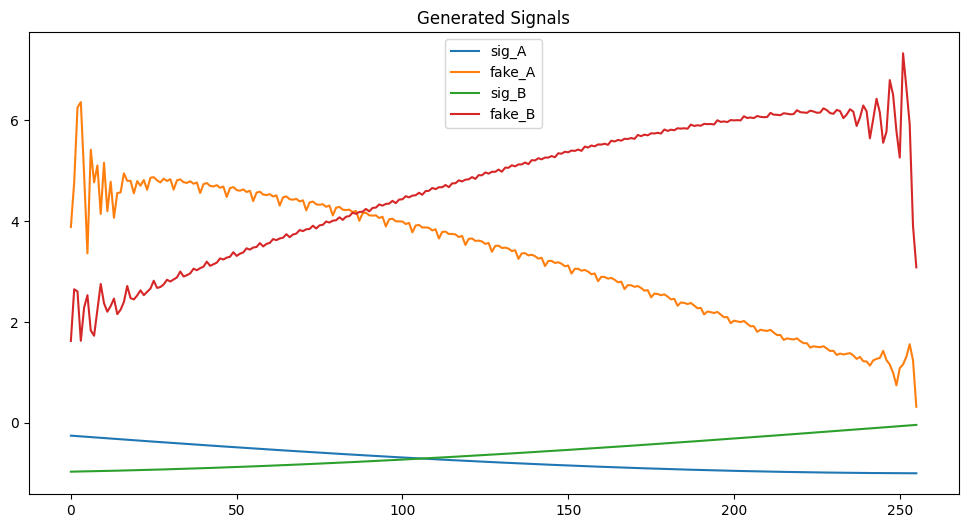

In [14]:
# load csv
df = pd.read_csv('generated_signals.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# plot df
df.plot(figsize=(12, 6), title='Generated Signals')

# save plot
plt.savefig('{}_to_{}.png'.format(SIG_A, SIG_B), bbox_inches='tight')